<a href="https://colab.research.google.com/github/hariszaf/metabolic_toy_model/blob/main/Antony2025/DNNGIORtraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Use DNNGIOR On Your Own Training Set**

Installing Tensorflow

In [ ]:
!pip install tensorflow==2.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Antony/

/content/drive/MyDrive/Antony


In [ ]:
!pip install cobra
!pip install dnngior --no-deps
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.7/117.7 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 72.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dnngior 0.0.5 requires cobra<=0.23.0, but you have cobra 0.29.1 which is incompatible.
dnngior 0.0.5 requires gurobip

Load dependecies

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
from dnngior import NN_Trainer
from dnngior import NN_Predictor
from dnngior import Gapfill
import tensorflow as tf

from cobra.io import read_sbml_model

Restricted license - for non-production use only - expires 2026-11-23
The rest of dnngior features can be used without it.


### Generating reaction presence dataframe

By default DNNGIOR uses a neural network trained on a best-per-species dataset, that has learned the coocurences of reactions encoded by the genomes. If we want to train our own network we need to prepare our own training data we need to take a set genomes and determine the reactions present. The easiest way for this is to take the draft models of our genomes and generate a binary array encoding which models contain which reactions.

We need a list of all possible reactions found in our training data, which will serve as the rows in our dataset. There are actually several ways to do this, below is the way we did it. As loading the models take relatively long, we will also keep track of the reactions in model_reaction_dic.

For this tutorial, we will use the reaction class from dnngior but you can use any module to load metabolic models or extract the reaction sets in another way.

In [1]:
#path to training models
model_path =  '/content/drive/MyDrive/Antony/one_per_phylum_models'

#list of model-ids of draft-models
paths  = os.listdir(model_path)[:5]
model_ids = []
for filename in paths:
    model_ids.append(filename[:-5])


model_reaction_dic = {}
rxn = []
for file_path, model_id in zip(paths,model_ids):
    print(model_id)
    model = read_sbml(os.path.join(model_path, file_path))
    rs = set(model.reactions.list_attr('id'))
    model_reaction_dic[model_id]=rs

    #generate a list of all possible reactions
    for i in list(rs):
         if i not in rxn and not i.startswith('EX_'):
             rxn.append(i)

ModuleNotFoundError: No module named 'dnngior'

We can then determine for every draft training models which of these reactions are present and create a binary list of reactions presences. We will end up with a binary array with as rows the different reactions and as columns all models in the training dataset.

In [ ]:
#output path training data
output_path = 'one_per_phylum_training_data.csv'

reaction_df=pd.DataFrame(index=rxn, columns=model_ids)

for key, value in model_reaction_dic.items():
    a = []
    for i in rxn:
        if i in value:
            a.append(1)
        else:
            a.append(0)
    reaction_df[key]=a

#saving to pandas file
reaction_df.to_csv(output_path)

We can have a look at the distribution of reaction set sizes to see if the extraction was succesful.

<Axes: >

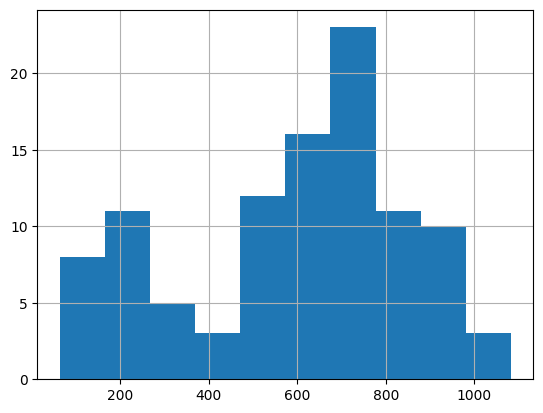

In [ ]:
reaction_df.sum().hist()

### Training the Neural Network

Now that we have prepared the training data, we can start training the network. During training the network will generate the feature by randomly deleting reactions from the input data and then try to predict the missing reactions.

We do this using the train function of the `NN_Trainer` class. This function will return a object of the predictor class (`NN_predictor`) containing the network, the reaction keys and modeltype. If a `output_path` is provided, it will also save it as a npz file.


In [ ]:
#Load in a our training sample
training_data_path = 'one_per_phylum_training_data.csv'
training_data = pd.read_csv(training_data_path, index_col=0)

#set save path
save_path = 'NN_phylum.npz'

#Train the network
NN_example = NN_Trainer.train(data=training_data, modeltype='ModelSEED',output_path=save_path)

print("The weights of the first layer of the network: \n{}".format(NN_example.network[0][0]))
print("The rxn_keys: \n{}".format(NN_example.rxn_keys.values))
print("The Modeltype: {}".format(NN_example.modeltype))

Num GPUs Available:  0
# WARNING: overwriting savefile
using data as labels
dataset created
training on data with shape: (3060, 1996) with 1482342.0 reactions
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               511232    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1996)              512972    
                                                                 
Total params: 1024204 (3.91 MB)
Trainable params: 1024204 (3.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 3060 samples
Epoch 1/10
3060/3060 [==============================] - 2s 564us/sample - loss: 0.0520 - auc_1: 0.9

 By default the network in the NN_predictor is not a full tensorflow object but rather an array of the weights and biases of the different layers. It can still be used to make predictions while being less memory intensive by using matrix multiplication:

        a = input
        for layer in self.network:
            a = a.clip(0)
            a = ((a @ layer[0]) + layer[1])
        prediction =  1 / (1 + np.exp(-a))#sigmoid(a)
        
Which is build into the NN_Predictor class.

### Making predictions

As expected we can now use the network to make predictions and to guide gapfilling. We can have the gapfiller use the new network to gapfill models using the `trainedNNPath` argument from the gapfill class

#reactions not found in NN-keys:  65 / 726


<Axes: >

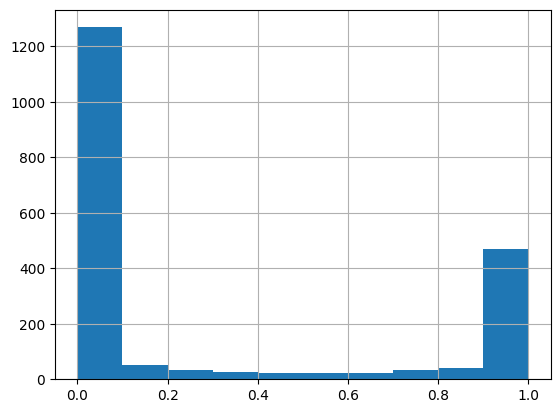

In [ ]:
path_to_draft_model = '/content/drive/MyDrive/Antony/Bifidobacterium adolescentis_atcc_15703.sbml'
draft_model = read_sbml_model(path_to_draft_model)
p = NN_example.predict(draft_model)
pd.Series(p).hist()
#gapfill_model_custom_nn = Gapfill(draftModel = path_to_draft_model, objectiveName = 'bio1', trainedNNPath='NN_phylum.npz')


### For the interested: Changing feature generation parameters

Basically you now know how to train networks but there are many additional changes you want to make during training.

During training the `generate_feature` function will automatically generate the training dataset. You can change several parameters for the generation of the feature:

1. You can change the number of times each training model is used (nuplo, default=30).
2. You can change the range of deletion percentages (min_for and max_for, default = 0.05 and 0.3), which will be removed in equal sized steps based on the number of replicates.
3. You can weigh the deletion of certain reactions (del_p, default=None).
4. You can also add false reactions (min_con and max_con) during training and change wthe weights of addition (con_p)*

*Note: we do not currently use this and it will not work with the masking of input reactions as the mask does not differentiate between contamination and real reactions.

In the following example we set nuplo to 300 instead of 30, and we vary deletion between 0.2 and 0.5.

`custom_feature = NN_Trainer.generate_feature(training_data, nuplo=300, min_con=0, max_con=0, min_for = 0.2, max_for = 0.5, del_p = None, con_p = None)`

For convenience you can give the parameters to the train function and they will be passed on, so there is not that much reason to generate the feature manually.


In [ ]:
network = NN_Trainer.train(data=training_data, nuplo=300, min_for=0.2, max_for=0.5, modeltype='ModelSEED',save=False)

Num GPUs Available:  0
using data as labels
dataset created
training on data with shape: (30600, 1996) with 11701038.0 reactions
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               511232    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1996)              512972    
                                                                 
Total params: 1024204 (3.91 MB)
Trainable params: 1024204 (3.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 30600 samples
Epoch 1/10
30600/30600 [==============================] - 20s 669us/sample - loss: 0.0160 - auc_4: 0.9977 - precision_4: 0.9726 

By default the network will asume that your input (the data without deletions) should be what the network tries to predict. Alternatively, you can provide labels (the full set of reactions) for the network to try and predict. The following is a slightly convoluted way to have the network only predict missing reactions and have it predict reactions already present as 0.

In [ ]:
manual_feature = NN_Trainer.generate_feature(training_data.T, nuplo=30, min_con=0, max_con=0, min_for = 0.05, max_for = 0.3, del_p = None, con_p = None)
manual_training_data = pd.DataFrame(columns = training_data.index, data=manual_feature)
manual_labels = 1 - manual_feature

network = NN_Trainer.train(data=manual_training_data, rxn_keys=training_data.index, labels=manual_labels, maskI=False, min_for=0.0, max_for=0.0, modeltype='ModelSEED',save=False)

Num GPUs Available:  0
using user provided labels
dataset created
training on data with shape: (59880, 3060) with 41452482.0 reactions
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               783616    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 3060)              786420    
                                                                 
Total params: 1570036 (5.99 MB)
Trainable params: 1570036 (5.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 59880 samples
Epoch 1/10
59880/59880 [==============================] - 49s 826us/sample - loss: 0.0207 - auc_5: 0.8844 - precision_5: 0

Finally, you can rely on the default parameters to define the network which we optimised for our usecase, but for optimal perfomance on different datasets, you might want to change the hyperparameters (dropout, batch size), the architecture (nnodes, nlayers) or bias of predicted classes (bias0). You can also disable the masking of input positions during loss calculation (maskI=False). You can also provide a validation split which will set apart a part of your input data during training and calculate scores after to validate your network.

In [ ]:
network = NN_Trainer.train(data=training_data, dropout=0.2,b_size=42,nnodes = 420, nlayers=3, bias_0=0.42, maskI=False, validation_split=0.2, modeltype='ModelSEED',save=False)

### For the extra interested: Tensorflow object

By default the function returns a class with the simplified network but you very well might want instead the full Tensorflow network. To do this you can set return_full_network = True, which will change the NN_predictor to contain a Tensorflow network instead, there modeltype and rxn keys work the same. If you want to save this different class you need to change the file extension to .h5.

If you set return_history = True it will also return the history of training for optimisation purposes.

In [ ]:
save_path = os.path.join('NN_phylum.h5')

NN_tensorflow, history = NN_Trainer.train(data=training_data, return_full_network=True, modeltype='ModelSEED', output_path=save_path, return_history=True)

Num GPUs Available:  0
using data as labels
dataset created
training on data with shape: (3060, 1996) with 1482342.0 reactions
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               511232    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1996)              512972    
                                                                 
Total params: 1024204 (3.91 MB)
Trainable params: 1024204 (3.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Train on 3060 samples
Epoch 1/10
3060/3060 [==============================] - 2s 683us/sample - loss: 0.0517 - auc_2: 0.9311 - precision_2: 0.8898 - reca

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The main reason we dont use the full network is to save space and time, we can see that the tensorflow object is four times the size

In [ ]:
!ls NN_phylum* -lh

-rw-r--r-- 1 meine binf  16M Feb 28 16:52 NN_phylum.h5
-rw-r--r-- 1 meine binf 4.0M Feb 28 16:44 NN_phylum.npz


In [ ]:
print(NN_tensorflow.network.predict(test_input.T))
print(NN_tensorflow.rxn_keys)
print(NN_tensorflow.modeltype)

print("The summary of the network: \n{}".format(NN_tensorflow.network.summary()))
print("The bias of the first layer network: \n{}".format(NN_example.network[0][1]))
print("The rxn_keys: \n{}".format(NN_tensorflow.rxn_keys))
print("The Modeltype: {}".format(NN_example.modeltype))

[[9.8170334e-01 1.7333871e-01 6.5492481e-01 ... 3.6391240e-10
  6.9073259e-08 1.6098149e-09]
 [9.9994546e-01 9.1655158e-02 9.6405721e-01 ... 4.3539622e-08
  8.1443136e-07 1.3167903e-07]
 [1.8228114e-02 1.0808345e-03 8.2123652e-02 ... 5.4656033e-07
  3.4918975e-07 5.8884945e-07]]
Index(['rxn00141_c0', 'rxn08127_c0', 'rxn05466_c0', 'rxn10309_c0',
       'rxn24607_c0', 'rxn04791_c0', 'rxn00293_c0', 'rxn00214_c0',
       'rxn00187_c0', 'rxn01859_c0',
       ...
       'rxn05598_c0', 'rxn00015_c0', 'rxn05107_c0', 'rxn00639_c0',
       'rxn00971_c0', 'rxn02296_c0', 'rxn00914_c0', 'rxn02944_c0',
       'rxn00835_c0', 'rxn00291_c0'],
      dtype='object', length=2002)
ModelSEED
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               512768    
                                                                 
 dropout_2 (Dropout)         (None,

If you want to use the modelseed trained network to predict reactions you need to provide it with a binary array of reactions, its not as convenient so I would only use the tensorflow object when you want to do more advanced tinkering.

In [ ]:
test_input = training_data.iloc[:,:3].values
p = NN_tensorflow.network.predict(test_input.T)
print("Prediction: \n{}".format(np.round(p,3)))

Prediction: 
[[0.982 0.173 0.655 ... 0.    0.    0.   ]
 [1.    0.092 0.964 ... 0.    0.    0.   ]
 [0.018 0.001 0.082 ... 0.    0.    0.   ]]


With the history you can do whatever you want, for example plot the loss function over the epochs.

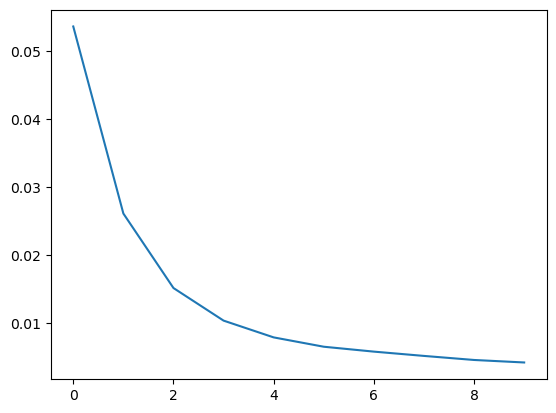

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])